In [22]:
import sqlite3
import pandas as pd
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

In [23]:
def calculate_distance(lat1, lon1):
    # Radius of the Earth in kilometers
    earth_radius = 6371

    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(44.4914)
    lon2_rad = math.radians(20.2744)

    # Calculate the differences between the latitudes and longitudes
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

In [24]:
import sqlite3

values = ["SUT", "PSUT", "PR", "VPR"]

mapping = {
    "SUT": 0,
    "PSUT": 0.25,
    "PR": 0.5,
    "VPR": 0.75
}

# Connect to the database
conn = sqlite3.connect('db_prodaja-stanova_beograd.db')

# Create a cursor object
cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM mytable", conn)

# Execute a SELECT query
cursor.execute("SELECT * FROM mytable")

X_data = list()
Y_data = list()
full_data = list()

# Fetch and print rows one by one
row1 = cursor.fetchone()
row = cursor.fetchone()
while row is not None:
    # print(row)
    coordinates = row[4]
    latitude, longitude = coordinates.split(',')
    distance = calculate_distance(float(latitude), float(longitude))
    

    broj_soba = row[5]

    if broj_soba == None:
        row = cursor.fetchone()
        continue
    broj_soba = float(broj_soba) if broj_soba != '5+' else 5.0


    kvadratura = float(row[6])
    if kvadratura == None:
        row = cursor.fetchone()
        continue


    sprat = row[7]
    if sprat == None:
        row = cursor.fetchone()
        # print(sprat)
        continue
    if sprat in values:
        sprat = mapping[sprat]
    else:
        sprat = float(sprat)
    sprat = math.log2(sprat + 1)


    # print(row)

    tip_gradnje = row[8]
    tip_gradnje = 1 if tip_gradnje == 'Novogradnja' else 0
    # else:
    #     break
    uknjizen = float(row[9])
    lift = float(row[10])
    garaza = float(row[11])
    terasa = float(row[12])
    pdv = float(row[13])

    cena = float(row[16])
    # , legal, air_c, elevator, garage

    row_x_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv]
    row_full_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv, cena]
    full_data.append(row_full_data)
    X_data.append(row_x_data)
    Y_data.append(cena)

    row = cursor.fetchone()

# Close the connection
conn.close()

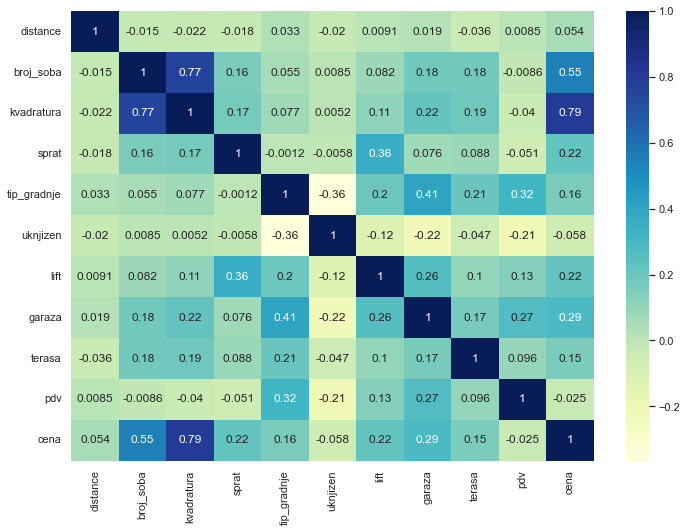

In [25]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv', 'cena']
df = pd.DataFrame(full_data, columns=header)
price_ranges = [0, 50000, 100000, 150000, 200000, 500000, float('inf')]
categories = [0,1,2,3,4,5]
# corrM = df.corr()
# corrM
sns.set(rc={'figure.figsize':(11.7,8.27)})
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


In [26]:
df['cena'] = pd.cut(df['cena'], bins=price_ranges, labels=categories)
df.head()

,distance,broj_soba,kvadratura,sprat,tip_gradnje,uknjizen,lift,garaza,terasa,pdv,cena
0,39.127679,3.0,68.0,1.000000,0,1.0,1.0,0.0,1.0,0.0,3
1,35.570932,2.5,75.0,3.459432,0,1.0,1.0,0.0,1.0,0.0,3
2,34.167384,3.0,69.0,2.000000,1,1.0,1.0,1.0,1.0,0.0,4
3,37.692401,4.0,146.0,4.169925,1,0.0,1.0,1.0,1.0,0.0,5
4,37.751948,4.0,125.0,2.000000,0,1.0,1.0,0.0,1.0,0.0,4


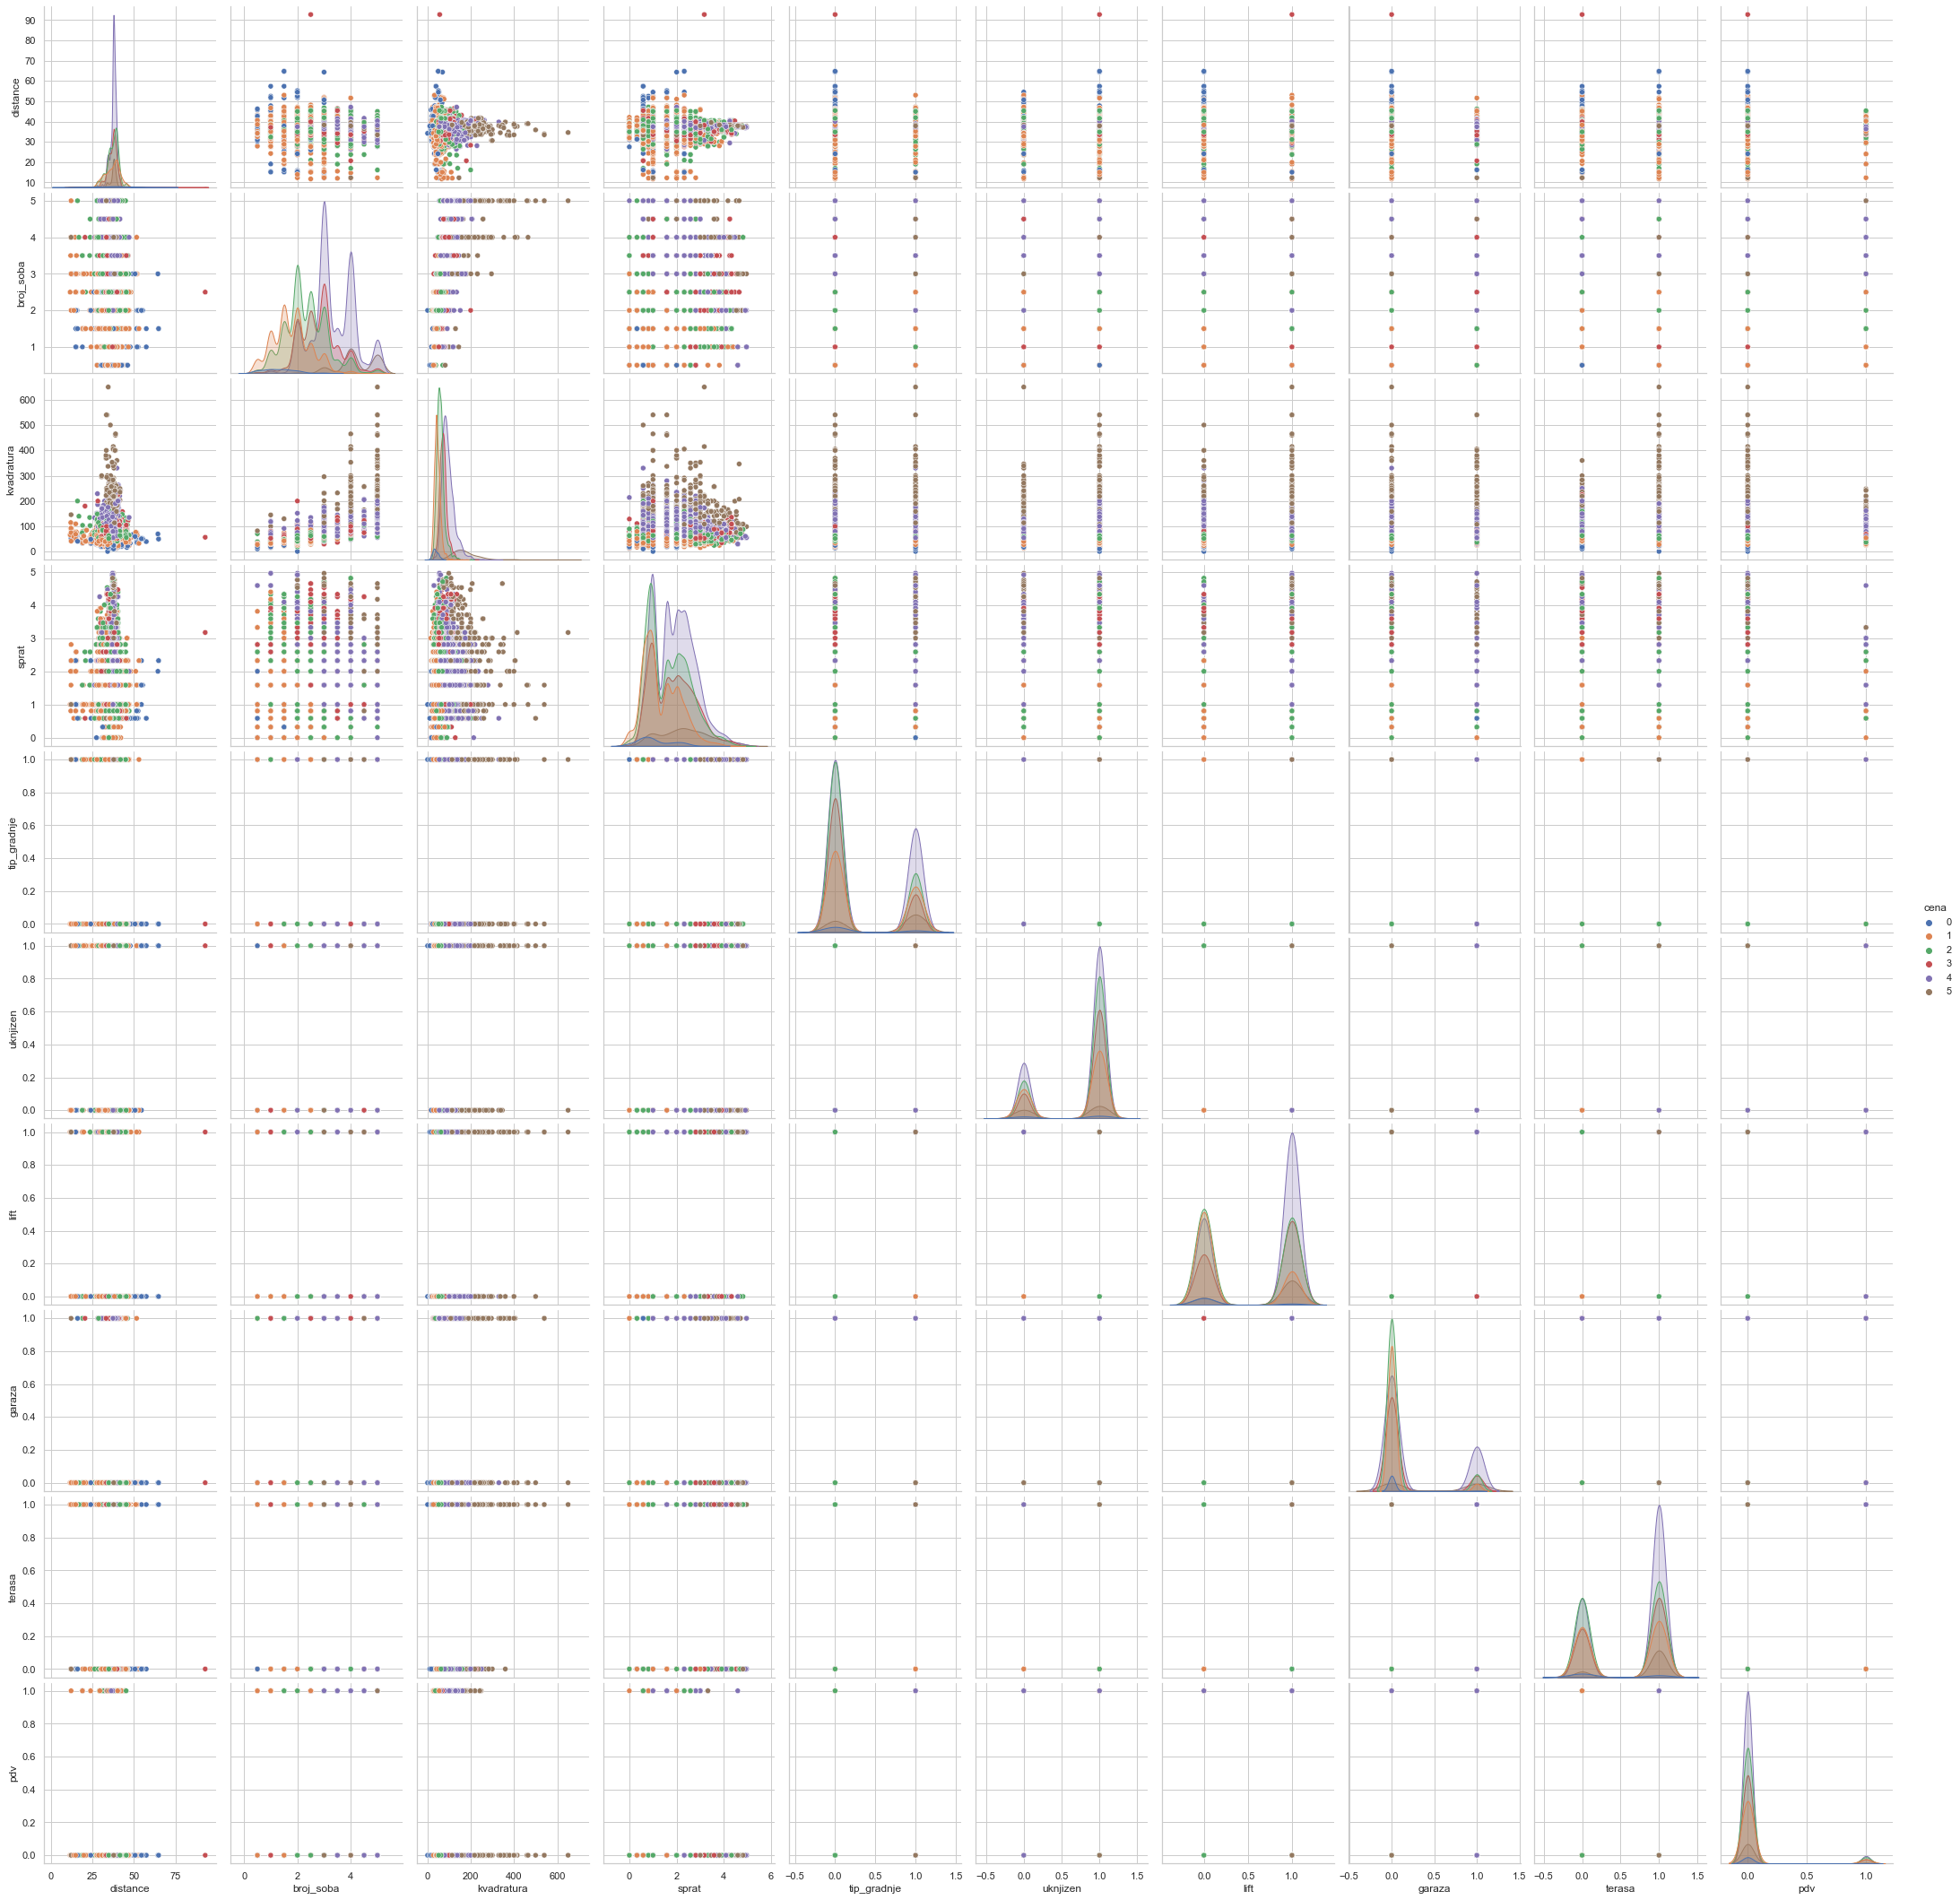

In [27]:
plt.close()
sns.set_style('whitegrid')
sns.pairplot(df, hue='cena', height=3)
plt.show()

In [36]:
print(type(df['distance']))

<class 'pandas.core.series.Series'>


In [28]:
def knn_wrapped(X_train, y_train, X_test, y_test, n_neighbors):
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [62]:
temp_header = list()
acc_list = list()
header_i = header.copy()
# header_i = [x for x in header_i if x != 'kvadratura']
# temp_header.append('kvadratura')

X_train, X_test, y_train, y_test = train_test_split(X_data_minmax, y_data,test_size=0.2, random_state = 1)
df_train = pd.DataFrame(X_train, columns=header)
df_test = pd.DataFrame(X_test, columns=header)
while len(header_i)>0:
    best_score = 0
    for elem in header_i:
        new_header = temp_header.copy()
        new_header.append(elem)
        X_train_temp = df_train.loc[:, new_header].values.tolist()
        X_test_temp = df_test.loc[:, new_header].values.tolist()
        # print(X_train_temp)
        # print(len(X_train_temp))
        # print(type(X_test_temp))
        # print(len(X_test_temp))
        temp_score = knn_wrapped(X_train_temp, y_train, X_test_temp, y_test, 4)
        if temp_score > best_score:
            best_elem = elem
            best_score = temp_score.copy()
    print(best_elem)
    print(best_score)
    temp_header.append(best_elem)
    header_i = [x for x in header_i if x != best_elem]
    print(header_i)


kvadratura
0.4522319566124322
['distance', 'broj_soba', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
distance
0.6499791405924071
['broj_soba', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
sprat
0.6937838965373383
['broj_soba', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
tip_gradnje
0.6996245306633292
['broj_soba', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
pdv
0.6958698372966208
['broj_soba', 'uknjizen', 'lift', 'garaza', 'terasa']
lift
0.685857321652065
['broj_soba', 'uknjizen', 'garaza', 'terasa']
garaza
0.6766791823112224
['broj_soba', 'uknjizen', 'terasa']
uknjizen
0.6608260325406758
['broj_soba', 'terasa']
terasa
0.6424697538589904
['broj_soba']
broj_soba
0.5986649979140592
[]


In [30]:

header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
df_x = pd.DataFrame(X_data, columns=header)
y_data = df['cena']
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(X_data)
print(type(header))
print(X_data)

<class 'list'>
[[39.12767933042164, 3.0, 68.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 0.0], [35.570932018459246, 2.5, 75.0, 3.4594316186372973, 0, 1.0, 1.0, 0.0, 1.0, 0.0], [34.1673844457319, 3.0, 69.0, 2.0, 1, 1.0, 1.0, 1.0, 1.0, 0.0], [37.6924012077121, 4.0, 146.0, 4.169925001442312, 1, 0.0, 1.0, 1.0, 1.0, 0.0], [37.75194797024677, 4.0, 125.0, 2.0, 0, 1.0, 1.0, 0.0, 1.0, 0.0], [34.35007585972681, 3.0, 85.0, 1.584962500721156, 0, 1.0, 1.0, 0.0, 1.0, 0.0], [33.806846333969546, 5.0, 136.0, 1.584962500721156, 1, 1.0, 0.0, 1.0, 1.0, 0.0], [40.65266966911247, 1.5, 36.0, 1.584962500721156, 1, 0.0, 0.0, 0.0, 0.0, 0.0], [38.97558795478795, 3.0, 125.0, 2.321928094887362, 0, 1.0, 1.0, 0.0, 1.0, 0.0], [32.76750839852794, 2.0, 46.0, 3.321928094887362, 0, 1.0, 0.0, 0.0, 1.0, 0.0], [35.75304294490641, 3.0, 71.0, 1.0, 1, 1.0, 0.0, 0.0, 1.0, 0.0], [38.003994159577616, 2.0, 65.35, 1.0, 0, 0.0, 1.0, 1.0, 1.0, 0.0], [31.927427355533766, 2.5, 59.0, 0.8073549220576041, 0, 1.0, 1.0, 0.0, 0.0, 0.0], [37.76654425165763

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.2, random_state = 1)
knn_clf=KNeighborsClassifier(n_neighbors=4)
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test)
result = confusion_matrix(y_test, ypred)
print("confusion matrix")
print(result)
result1 = classification_report(y_test, ypred)
print("classification report:",)
print (result1)
result2 = accuracy_score(y_test,ypred)
print("accuracy:",result2)


confusion matrix
[[ 12  12   1   0   0   0]
 [ 10 272  79  10   9   0]
 [  0 110 429  59  35   0]
 [  0  16  87 275  69   1]
 [  0   3  48 107 633  14]
 [  0   0   0   1  40  65]]
classification report:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51        25
           1       0.66      0.72      0.69       380
           2       0.67      0.68      0.67       633
           3       0.61      0.61      0.61       448
           4       0.81      0.79      0.80       805
           5       0.81      0.61      0.70       106

    accuracy                           0.70      2397
   macro avg       0.68      0.65      0.66      2397
weighted avg       0.71      0.70      0.70      2397

accuracy: 0.7033792240300375
